In [17]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity as sklearn_similarity
from scipy.spatial.distance import pdist, squareform, mahalanobis
from numpy.linalg import inv
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

In [18]:
def calculate_similarities(embeddings_file, labels_file):
    """
    Calculate multiple similarity metrics between protein embeddings and merge with labels
    """
    # Read embeddings
    embeddings_df = pd.read_csv(embeddings_file, index_col=0)
    embeddings = embeddings_df.values
    protein_names = embeddings_df.index
    
    # Calculate different similarity/distance metrics
    similarities = {}
    
    # Cosine similarity
    cos_sim = sklearn_similarity(embeddings)
    similarities['cosine'] = pd.DataFrame(cos_sim, index=protein_names, columns=protein_names)
    
    # Euclidean distance
    euc_dist = squareform(pdist(embeddings, metric='euclidean'))
    similarities['euclidean'] = pd.DataFrame(euc_dist, index=protein_names, columns=protein_names)
    
    # Manhattan distance
    man_dist = squareform(pdist(embeddings, metric='cityblock'))
    similarities['manhattan'] = pd.DataFrame(man_dist, index=protein_names, columns=protein_names)
    
    # Pearson correlation
    pearson_corr = np.corrcoef(embeddings)
    similarities['pearson'] = pd.DataFrame(pearson_corr, index=protein_names, columns=protein_names)
    
    # Get unique base protein names (without the suffixes)
    base_proteins = set(name.split('_')[0] for name in protein_names)
    
    # Calculate pairwise similarities for each metric
    results_data = []
    
    for protein_base in base_proteins:
        # Get all variants for this protein
        variants = [name for name in protein_names if name.startswith(protein_base + '_')]
        
        # Skip if we don't have enough variants
        if len(variants) < 2:
            continue
            
        # Get the annotated variant
        annotated = next((v for v in variants if 'Annotated' in v), None)
        if not annotated:
            continue
            
        # Compare annotated with extended and truncated variants
        for variant in variants:
            if variant != annotated:  # Don't compare annotated with itself
                metric_values = {
                    f'{metric}_similarity': sim_df.loc[annotated, variant]
                    for metric, sim_df in similarities.items()
                }
                
                metric_values.update({
                    'Protein': protein_base,
                    'Variant_Type': 'Extended' if 'Extended' in variant else 'Truncated'
                })
                results_data.append(metric_values)
    
    similarities_df = pd.DataFrame(results_data)
    
    # Process labels data
    labels_df = pd.read_csv(labels_file, index_col=0)
    metadata = []
    
    for protein_base in base_proteins:
        # Get rows for this protein
        protein_rows = labels_df[labels_df['Gene'] == protein_base]
        if len(protein_rows) < 2:
            continue
            
        # Get annotated variant
        annotated_row = protein_rows[protein_rows.index.str.contains('Annotated')].iloc[0]
        
        # Compare with other variants
        other_rows = protein_rows[~protein_rows.index.str.contains('Annotated')]
        for _, variant_row in other_rows.iterrows():
            metadata.append({
                'Protein': protein_base,
                'Variant_Type': 'Extended' if 'Extended' in variant_row.name else 'Truncated',
                'Annotated_Localization': annotated_row['Localization'],
                'Variant_Localization': variant_row['Localization'],
                'Same_Localization': annotated_row['Localization'] == variant_row['Localization'],
                'Annotated_Correct': annotated_row['Correct prediction?'],
                'Variant_Correct': variant_row['Correct prediction?']
            })
    
    metadata_df = pd.DataFrame(metadata)
    
    # Merge similarities with metadata
    output_df = metadata_df.merge(similarities_df, on=['Protein', 'Variant_Type'])
    
    return output_df

def analyze_metric_correlations(df):
   """
   Analyze correlations between different similarity metrics and localization
   
   Parameters:
   -----------
   df : pandas.DataFrame
       DataFrame containing similarity scores and metadata
   
   Returns:
   --------
   dict
       Dictionary containing statistical measures for each metric
   """
   metrics = [col for col in df.columns if col.endswith('_similarity')]
   df['Same_Localization_Numeric'] = df['Same_Localization'].astype(int)
   
   results = {}
   
   for metric in metrics:
       # Calculate correlations and t-tests
       correlation = df['Same_Localization_Numeric'].corr(df[metric])
       same_loc = df[df['Same_Localization']][metric]
       diff_loc = df[~df['Same_Localization']][metric]
       t_stat, p_value = stats.ttest_ind(same_loc, diff_loc)
       
       results[metric] = {
           'correlation': correlation,
           'p_value': p_value,
           't_statistic': t_stat,
           'same_loc_mean': same_loc.mean(),
           'same_loc_std': same_loc.std(),
           'same_loc_count': len(same_loc),
           'diff_loc_mean': diff_loc.mean(),
           'diff_loc_std': diff_loc.std(),
           'diff_loc_count': len(diff_loc)
       }
       
       # Print results
       print(f"\nResults for {metric}:")
       print(f"Correlation with Same_Localization: {correlation:.3f}")
       print(f"T-test p-value: {p_value:.3f}")
       print("\nSummary Statistics:")
       print("Same Localization:")
       print(f"Mean: {results[metric]['same_loc_mean']:.3f}")
       print(f"Std: {results[metric]['same_loc_std']:.3f}")
       print(f"Count: {results[metric]['same_loc_count']}")
       print("\nDifferent Localization:")
       print(f"Mean: {results[metric]['diff_loc_mean']:.3f}")
       print(f"Std: {results[metric]['diff_loc_std']:.3f}")
       print(f"Count: {results[metric]['diff_loc_count']}")
     
   return results

def plot_protein_metrics(df, model_name):
    """
    Create a strip plot showing all similarity metrics for each protein using Seaborn
    """
    # Get metrics columns
    metrics = [col for col in df.columns if col.endswith('_similarity')]
    
    # Setup the plot
    fig, axs = plt.subplots(1, len(metrics), figsize=(22, 6))
    
    # Define interpretation for each metric
    metric_interpretation = {
        'cosine_similarity': 'Higher = More Similar',
        'euclidean_similarity': 'Lower = More Similar', 
        'manhattan_similarity': 'Lower = More Similar',
        'pearson_similarity': 'Higher = More Similar'
    }
    
    # Create separate subplot for each metric
    for ax_idx, metric in enumerate(metrics):
        ax = axs[ax_idx]
        
        # Create the strip plot and store the points
        scatter = sns.stripplot(
            data=df,
            y=metric,
            hue='Same_Localization',
            palette={True: 'blue', False: 'red'},
            size=8,
            alpha=0.6,
            jitter=0.4,
            ax=ax
        )
        
        # Get the plotted points
        points = scatter.collections[0].get_offsets().data
        
        # Create a mapping of y-values to x-coordinates
        y_to_x = {y: x for x, y in points}
        
        # Add protein labels using the actual point positions
        for idx, row in df.iterrows():
            y_val = row[metric]
            # Find the corresponding x position
            x_pos = y_to_x.get(y_val, 0)
            
            ax.annotate(
                row['Protein'],
                xy=(x_pos, y_val),  # Use the actual point position
                xytext=(5, 0),      # Small offset to the right
                textcoords='offset points',
                fontsize=8,
                alpha=0.8,
                horizontalalignment='left',
                verticalalignment='center'
            )
        
        # Customize each subplot
        metric_name = metric.replace('_similarity', '').capitalize()
        ax.set_title(f'{metric_name}\n({metric_interpretation[metric]})', 
                    fontsize=10, pad=10)
        
        # Remove x ticks and labels
        ax.set_xticks([])
        ax.set_xlabel('')
        
        # Only show y label for first plot
        if ax_idx > 0:
            ax.set_ylabel('')
            
        # Remove the legend for all but the last subplot
        if ax_idx < len(metrics) - 1:
            ax.get_legend().remove()
        else:
            ax.legend(title='Same localization?', bbox_to_anchor=(1.05, 0.5))
    
    # Add main title
    plt.suptitle(f'{model_name}\nProtein Similarity Metrics by Localization Status',
                fontweight='bold', y=1.02)
    
    plt.tight_layout()
    plt.subplots_adjust(right=0.96, top=0.90, wspace=0.2)
    plt.show()
    
    return fig

In [20]:
labels_file = '/lab/barcheese01/mdiberna/plm_sandbox/output/isoform/process/isoform_labels.csv'

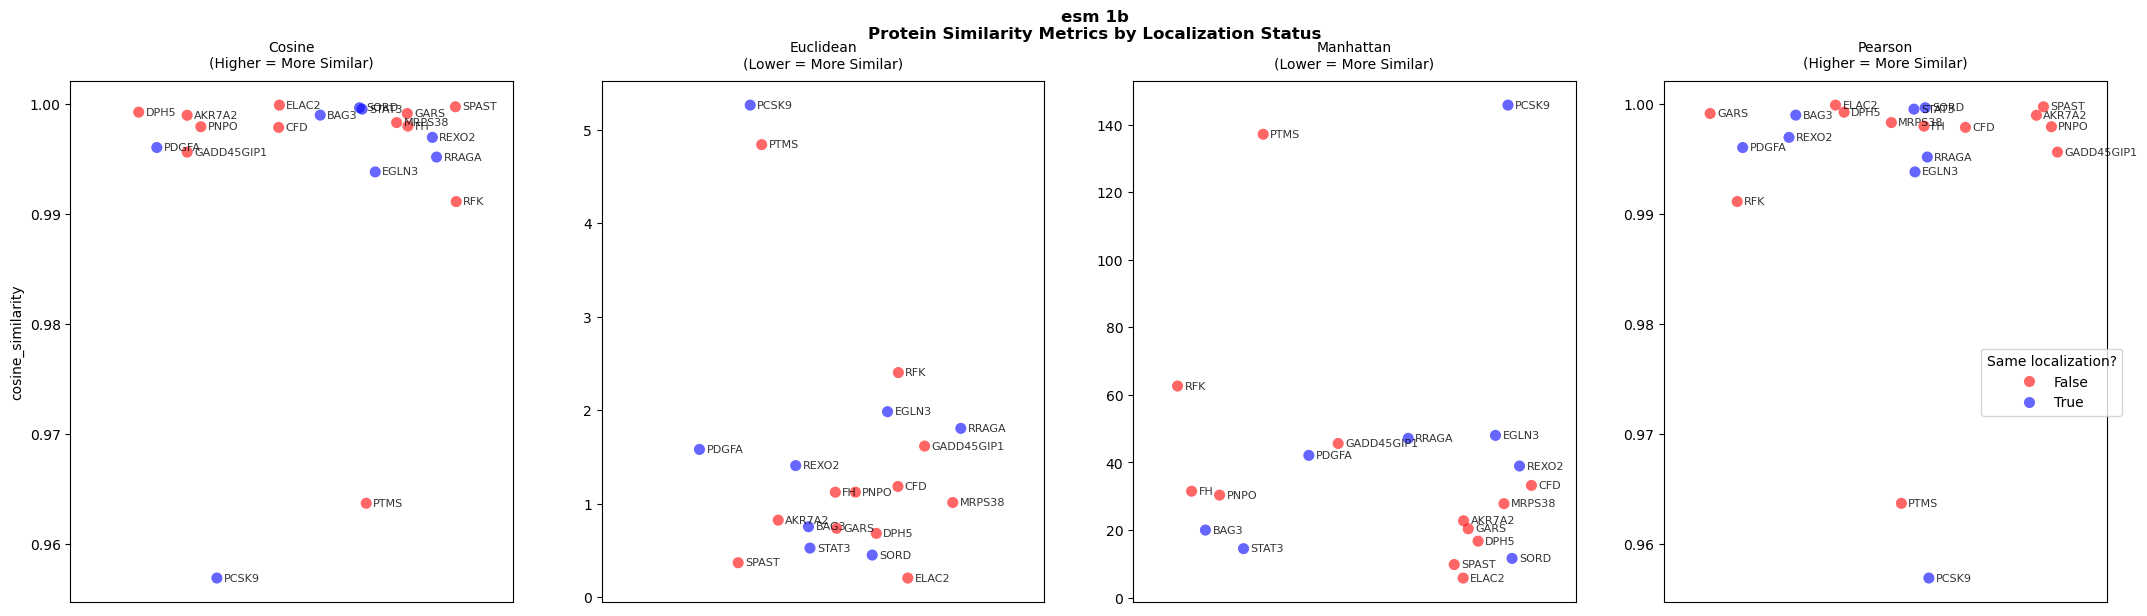


Results for cosine_similarity:
Correlation with Same_Localization: -0.121
T-test p-value: 0.611

Summary Statistics:
Same Localization:
Mean: 0.992
Std: 0.014
Count: 8

Different Localization:
Mean: 0.995
Std: 0.010
Count: 12

Results for euclidean_similarity:
Correlation with Same_Localization: 0.141
T-test p-value: 0.552

Summary Statistics:
Same Localization:
Mean: 1.723
Std: 1.545
Count: 8

Different Localization:
Mean: 1.345
Std: 1.242
Count: 12

Results for manhattan_similarity:
Correlation with Same_Localization: 0.121
T-test p-value: 0.611

Summary Statistics:
Same Localization:
Mean: 46.017
Std: 42.926
Count: 8

Different Localization:
Mean: 36.967
Std: 35.115
Count: 12

Results for pearson_similarity:
Correlation with Same_Localization: -0.121
T-test p-value: 0.611

Summary Statistics:
Same Localization:
Mean: 0.992
Std: 0.014
Count: 8

Different Localization:
Mean: 0.995
Std: 0.010
Count: 12


In [22]:
embeddings_file = '/lab/barcheese01/mdiberna/plm_sandbox/output/isoform/esm/isoform_sequences_esm1_esm1b_t33_650M_UR50S.csv'
similarity = calculate_similarities(embeddings_file, labels_file)
plot_protein_metrics(similarity, 'esm 1b')
results = analyze_metric_correlations(similarity)

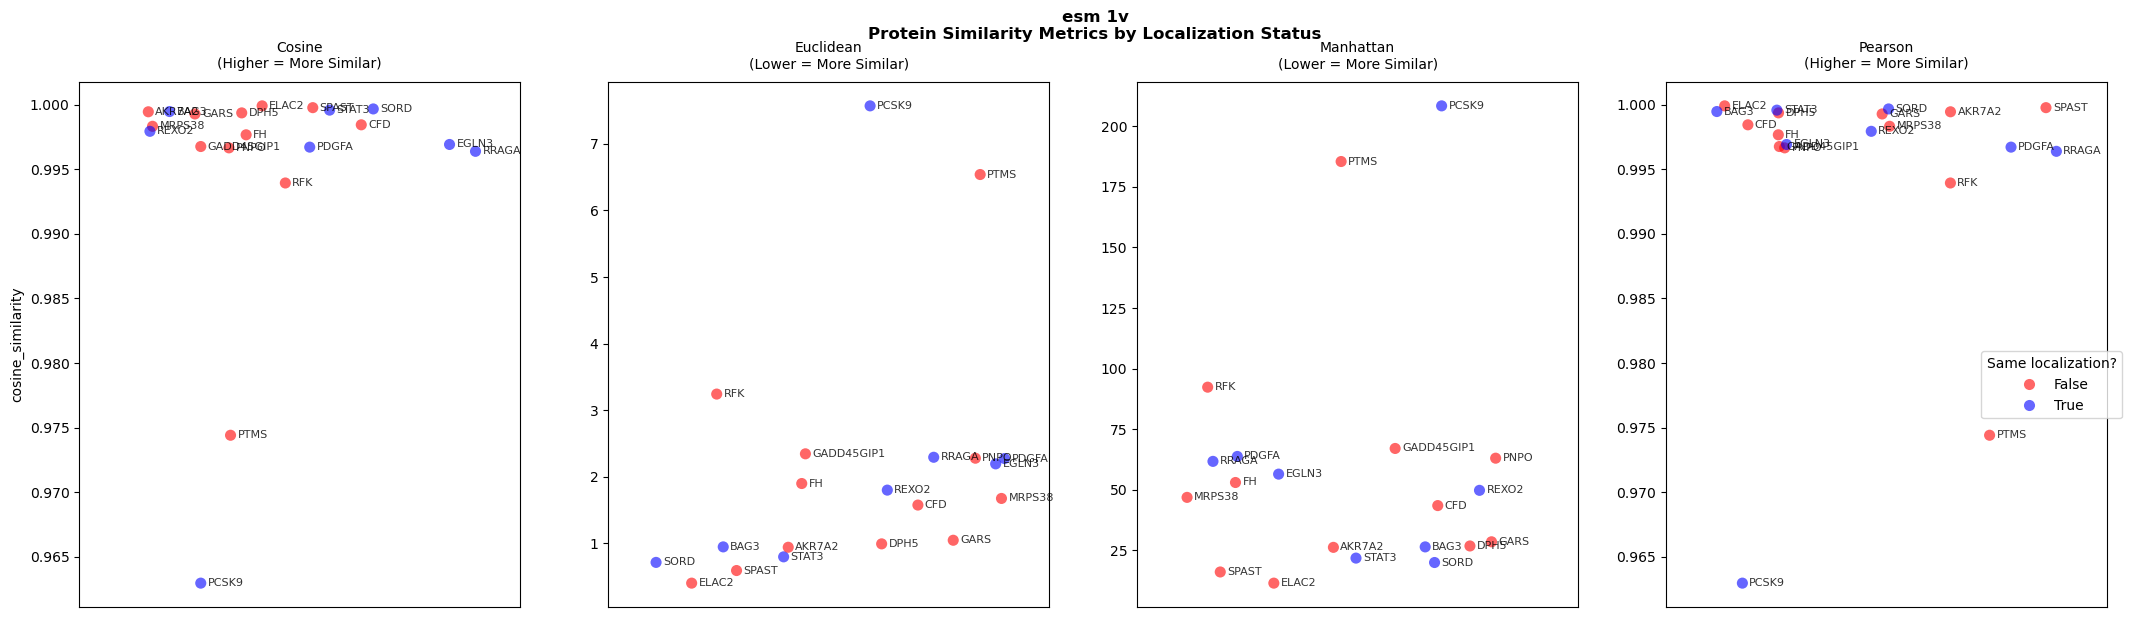


Results for cosine_similarity:
Correlation with Same_Localization: -0.132
T-test p-value: 0.580

Summary Statistics:
Same Localization:
Mean: 0.994
Std: 0.012
Count: 8

Different Localization:
Mean: 0.996
Std: 0.007
Count: 12

Results for euclidean_similarity:
Correlation with Same_Localization: 0.098
T-test p-value: 0.680

Summary Statistics:
Same Localization:
Mean: 2.324
Std: 2.225
Count: 8

Different Localization:
Mean: 1.961
Std: 1.657
Count: 12

Results for manhattan_similarity:
Correlation with Same_Localization: 0.082
T-test p-value: 0.730

Summary Statistics:
Same Localization:
Mean: 63.555
Std: 61.245
Count: 8

Different Localization:
Mean: 55.042
Std: 47.255
Count: 12

Results for pearson_similarity:
Correlation with Same_Localization: -0.132
T-test p-value: 0.580

Summary Statistics:
Same Localization:
Mean: 0.994
Std: 0.012
Count: 8

Different Localization:
Mean: 0.996
Std: 0.007
Count: 12


In [23]:
embeddings_file = '/lab/barcheese01/mdiberna/plm_sandbox/output/isoform/esm/isoform_sequences_esm1_esm1v_t33_650M_UR90S_1.csv'
similarity = calculate_similarities(embeddings_file, labels_file)
plot_protein_metrics(similarity, 'esm 1v')
results = analyze_metric_correlations(similarity)

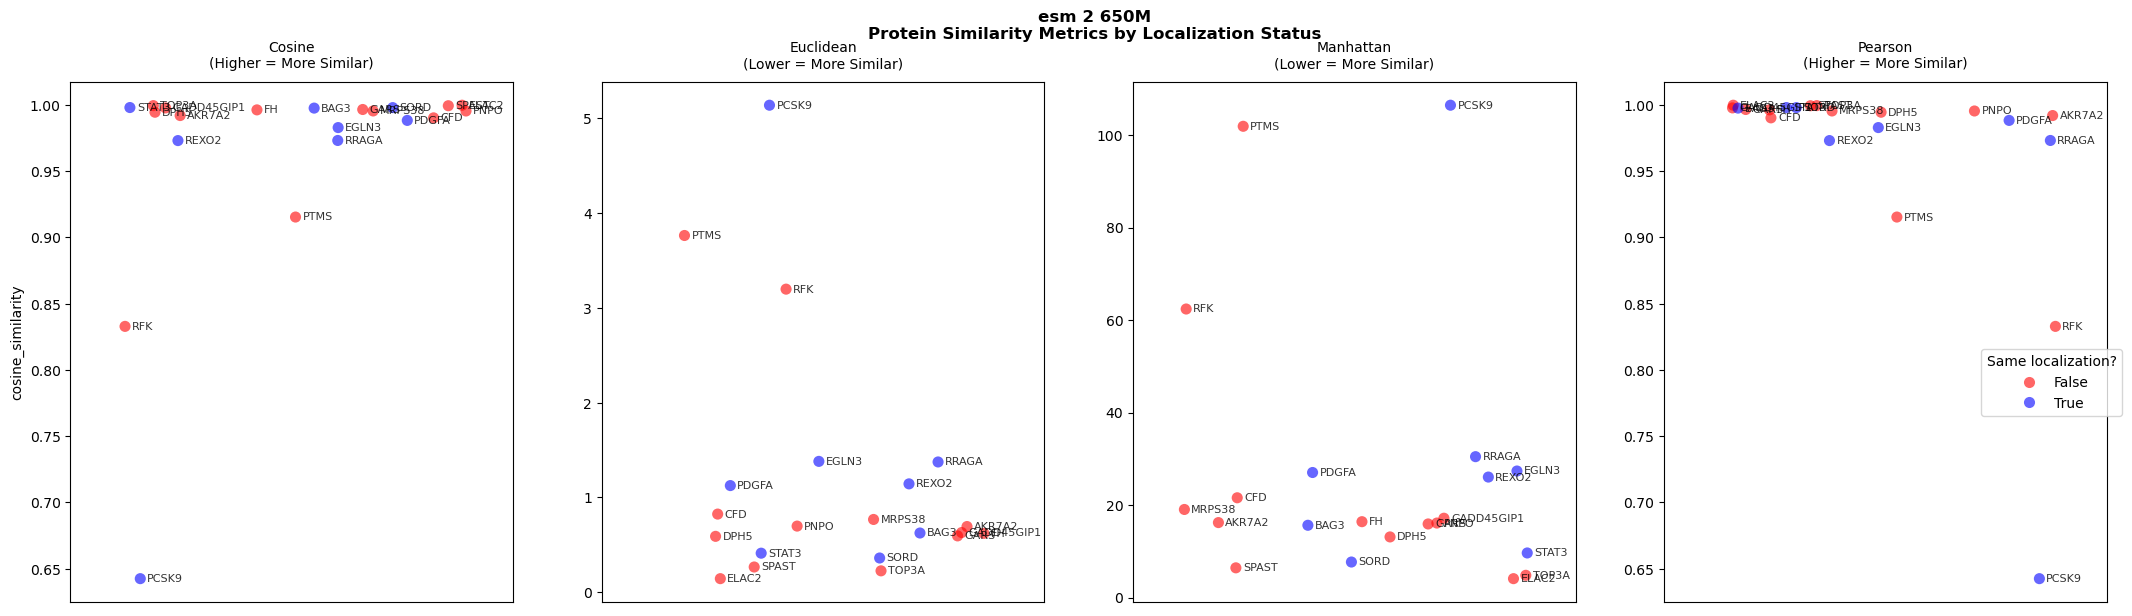


Results for cosine_similarity:
Correlation with Same_Localization: -0.198
T-test p-value: 0.390

Summary Statistics:
Same Localization:
Mean: 0.944
Std: 0.122
Count: 8

Different Localization:
Mean: 0.977
Std: 0.049
Count: 13

Results for euclidean_similarity:
Correlation with Same_Localization: 0.172
T-test p-value: 0.456

Summary Statistics:
Same Localization:
Mean: 1.445
Std: 1.546
Count: 8

Different Localization:
Mean: 1.001
Std: 1.126
Count: 13

Results for manhattan_similarity:
Correlation with Same_Localization: 0.123
T-test p-value: 0.595

Summary Statistics:
Same Localization:
Mean: 31.280
Std: 31.585
Count: 8

Different Localization:
Mean: 24.230
Std: 27.473
Count: 13

Results for pearson_similarity:
Correlation with Same_Localization: -0.198
T-test p-value: 0.390

Summary Statistics:
Same Localization:
Mean: 0.944
Std: 0.122
Count: 8

Different Localization:
Mean: 0.977
Std: 0.049
Count: 13


In [24]:
embeddings_file = '/lab/barcheese01/mdiberna/plm_sandbox/output/isoform/esm/isoform_sequences_esm2_t33_650M_UR50D.csv'
similarity = calculate_similarities(embeddings_file, labels_file)
plot_protein_metrics(similarity, 'esm 2 650M')
results = analyze_metric_correlations(similarity)

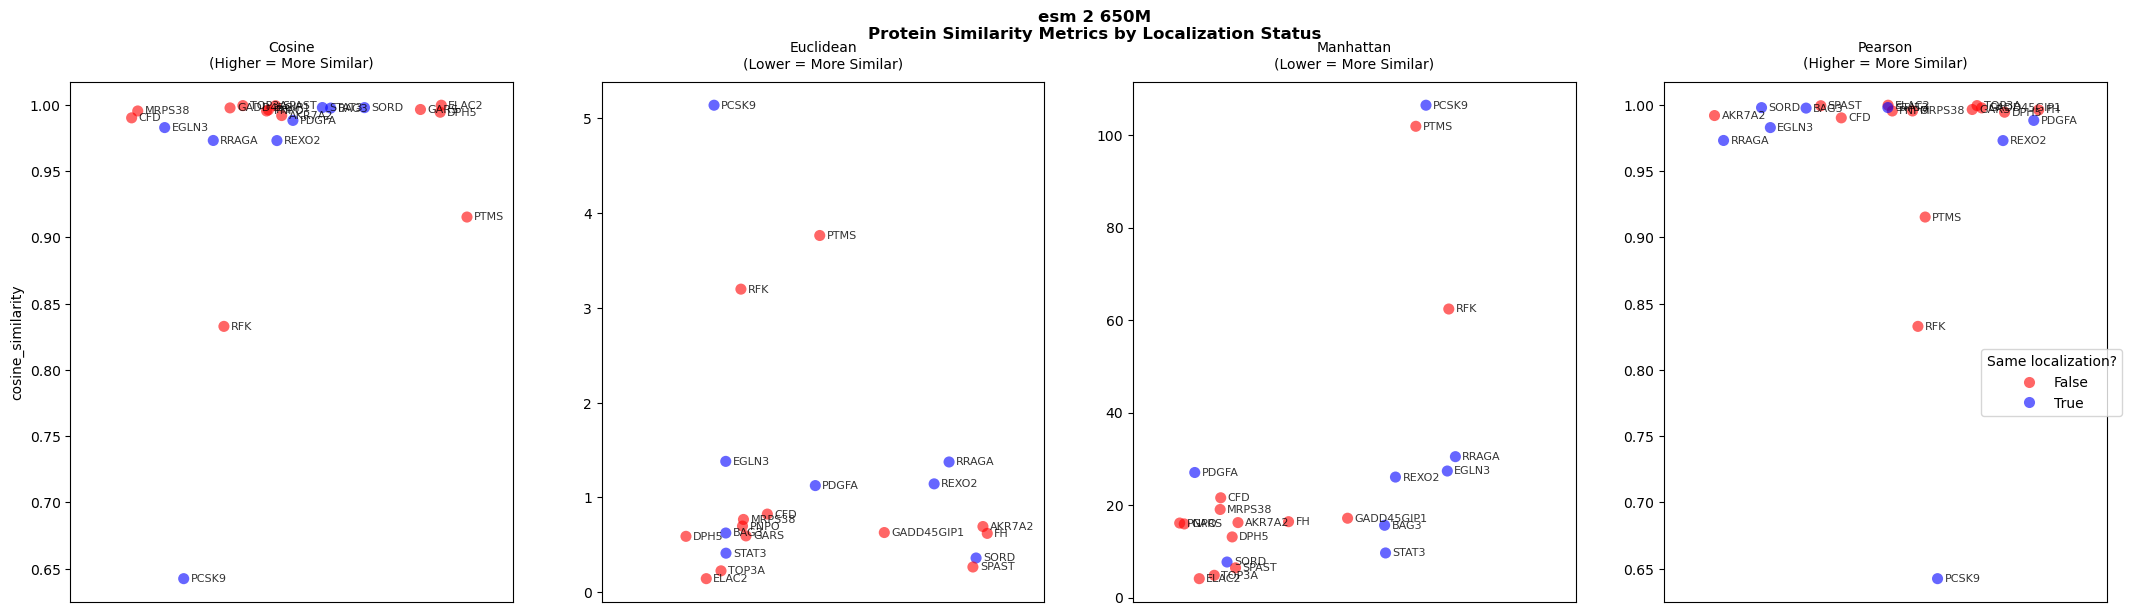


Results for cosine_similarity:
Correlation with Same_Localization: -0.198
T-test p-value: 0.390

Summary Statistics:
Same Localization:
Mean: 0.944
Std: 0.122
Count: 8

Different Localization:
Mean: 0.977
Std: 0.049
Count: 13

Results for euclidean_similarity:
Correlation with Same_Localization: 0.172
T-test p-value: 0.456

Summary Statistics:
Same Localization:
Mean: 1.445
Std: 1.546
Count: 8

Different Localization:
Mean: 1.001
Std: 1.126
Count: 13

Results for manhattan_similarity:
Correlation with Same_Localization: 0.123
T-test p-value: 0.595

Summary Statistics:
Same Localization:
Mean: 31.280
Std: 31.585
Count: 8

Different Localization:
Mean: 24.230
Std: 27.473
Count: 13

Results for pearson_similarity:
Correlation with Same_Localization: -0.198
T-test p-value: 0.390

Summary Statistics:
Same Localization:
Mean: 0.944
Std: 0.122
Count: 8

Different Localization:
Mean: 0.977
Std: 0.049
Count: 13


In [25]:
embeddings_file = '/lab/barcheese01/mdiberna/plm_sandbox/output/isoform/esm/isoform_sequences_esm2_t33_650M_UR50D.csv'
similarity = calculate_similarities(embeddings_file, labels_file)
plot_protein_metrics(similarity, 'esm 2 650M')
results = analyze_metric_correlations(similarity)

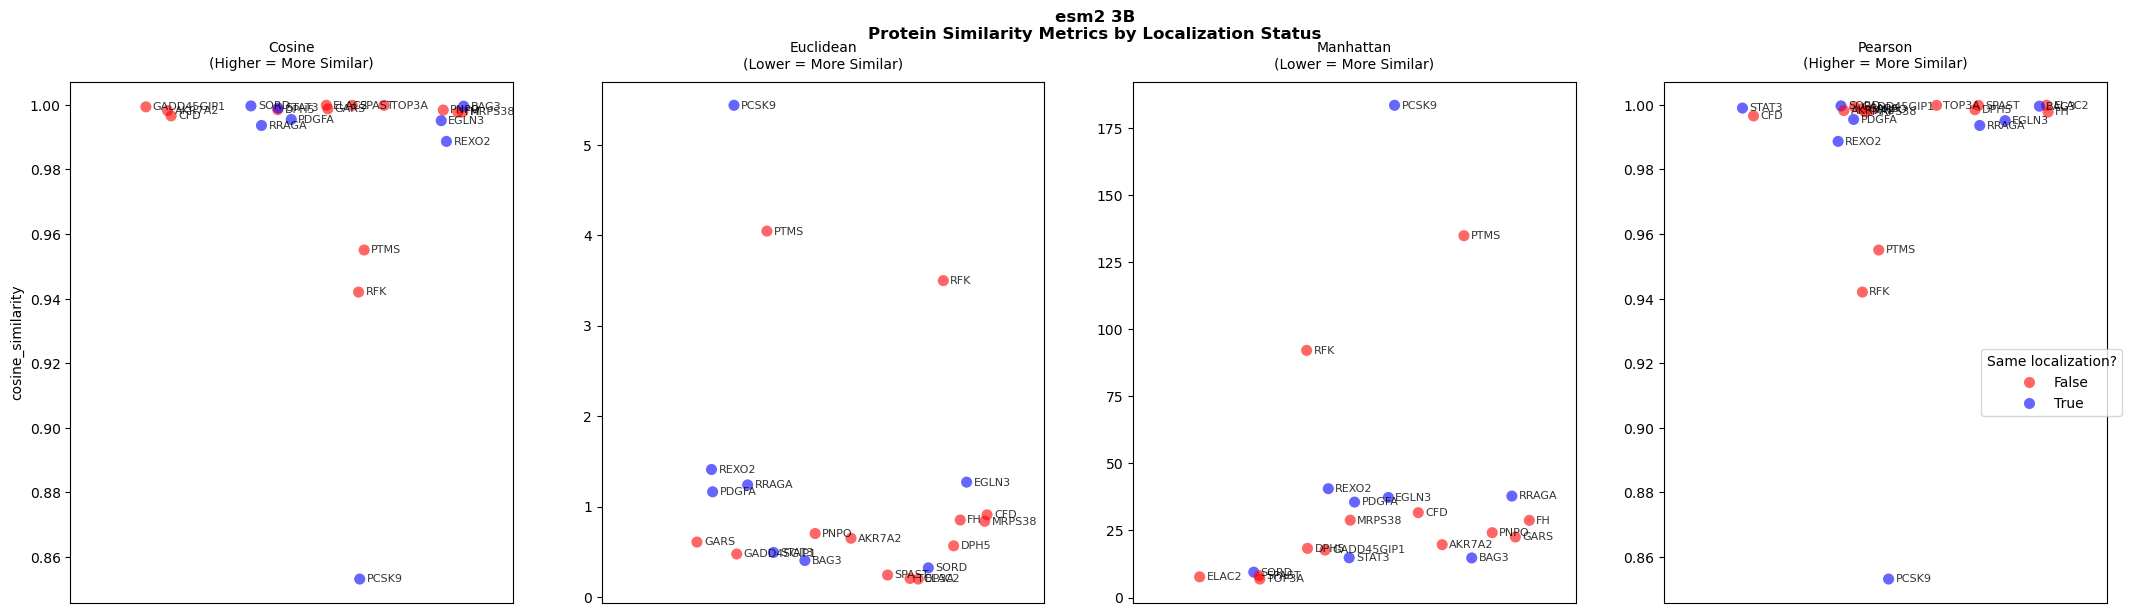


Results for cosine_similarity:
Correlation with Same_Localization: -0.189
T-test p-value: 0.412

Summary Statistics:
Same Localization:
Mean: 0.978
Std: 0.051
Count: 8

Different Localization:
Mean: 0.991
Std: 0.019
Count: 13

Results for euclidean_similarity:
Correlation with Same_Localization: 0.146
T-test p-value: 0.527

Summary Statistics:
Same Localization:
Mean: 1.467
Std: 1.661
Count: 8

Different Localization:
Mean: 1.060
Std: 1.231
Count: 13

Results for manhattan_similarity:
Correlation with Same_Localization: 0.142
T-test p-value: 0.539

Summary Statistics:
Same Localization:
Mean: 46.756
Std: 56.699
Count: 8

Different Localization:
Mean: 33.972
Std: 37.287
Count: 13

Results for pearson_similarity:
Correlation with Same_Localization: -0.189
T-test p-value: 0.412

Summary Statistics:
Same Localization:
Mean: 0.978
Std: 0.051
Count: 8

Different Localization:
Mean: 0.991
Std: 0.019
Count: 13


In [26]:
embeddings_file = '/lab/barcheese01/mdiberna/plm_sandbox/output/isoform/esm/isoform_sequences_esm2_t36_3B_UR50D.csv'
similarity = calculate_similarities(embeddings_file, labels_file)
plot_protein_metrics(similarity, 'esm2 3B')
results = analyze_metric_correlations(similarity)

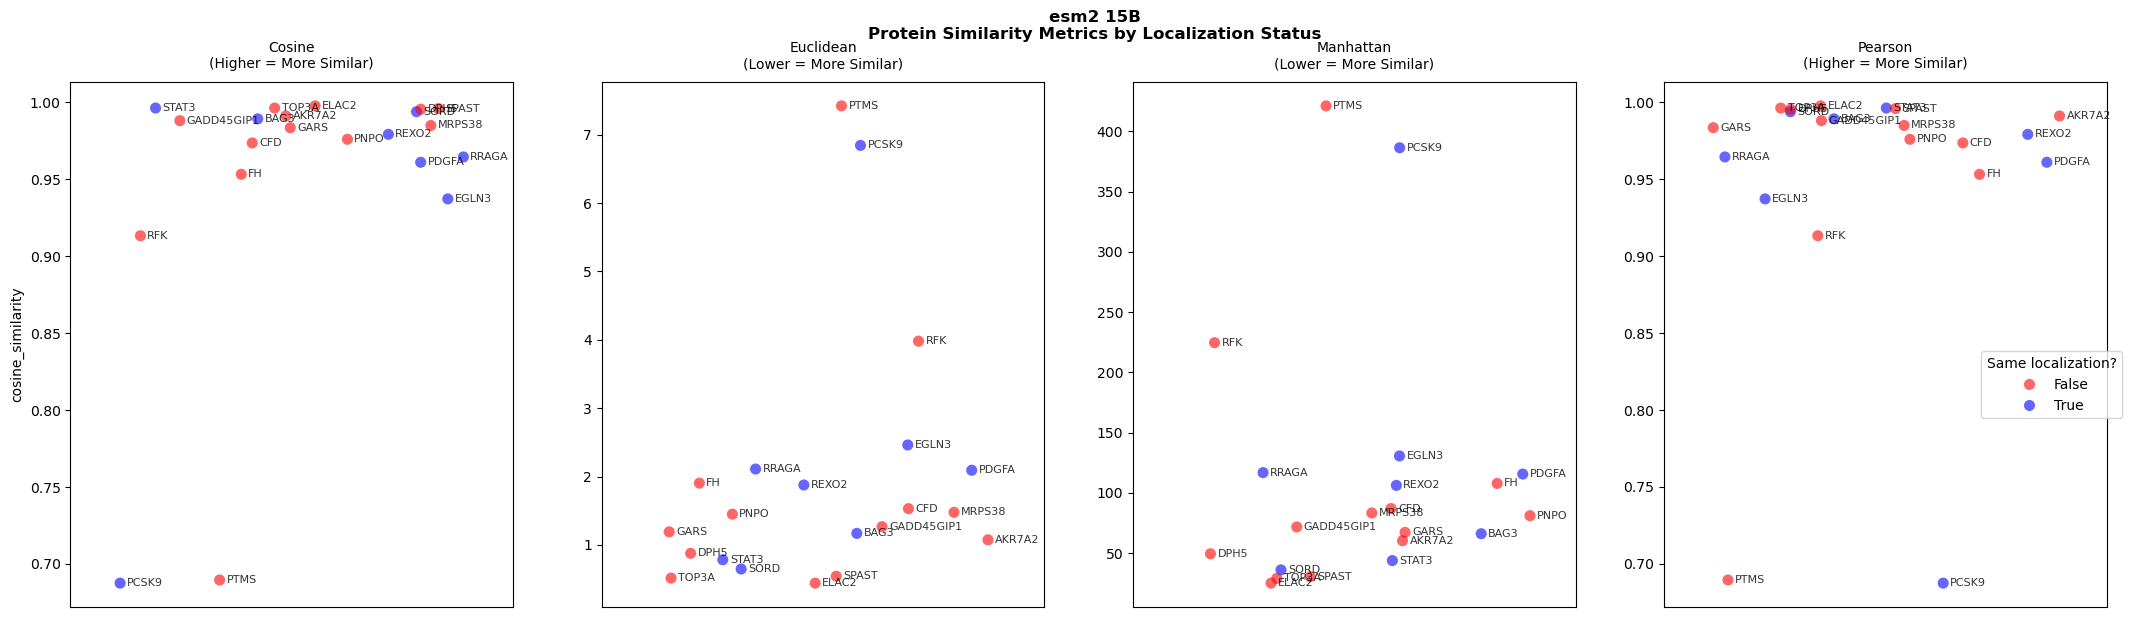


Results for cosine_similarity:
Correlation with Same_Localization: -0.101
T-test p-value: 0.662

Summary Statistics:
Same Localization:
Mean: 0.939
Std: 0.103
Count: 8

Different Localization:
Mean: 0.957
Std: 0.084
Count: 13

Results for euclidean_similarity:
Correlation with Same_Localization: 0.112
T-test p-value: 0.628

Summary Statistics:
Same Localization:
Mean: 2.249
Std: 1.972
Count: 8

Different Localization:
Mean: 1.821
Std: 1.910
Count: 13

Results for manhattan_similarity:
Correlation with Same_Localization: 0.103
T-test p-value: 0.656

Summary Statistics:
Same Localization:
Mean: 125.197
Std: 111.335
Count: 8

Different Localization:
Mean: 102.932
Std: 108.339
Count: 13

Results for pearson_similarity:
Correlation with Same_Localization: -0.101
T-test p-value: 0.662

Summary Statistics:
Same Localization:
Mean: 0.939
Std: 0.103
Count: 8

Different Localization:
Mean: 0.957
Std: 0.084
Count: 13


In [27]:
embeddings_file = '/lab/barcheese01/mdiberna/plm_sandbox/output/isoform/esm/isoform_sequences_esm2_t48_15B_UR50D.csv'
similarity = calculate_similarities(embeddings_file, labels_file)
plot_protein_metrics(similarity, 'esm2 15B')
results = analyze_metric_correlations(similarity)

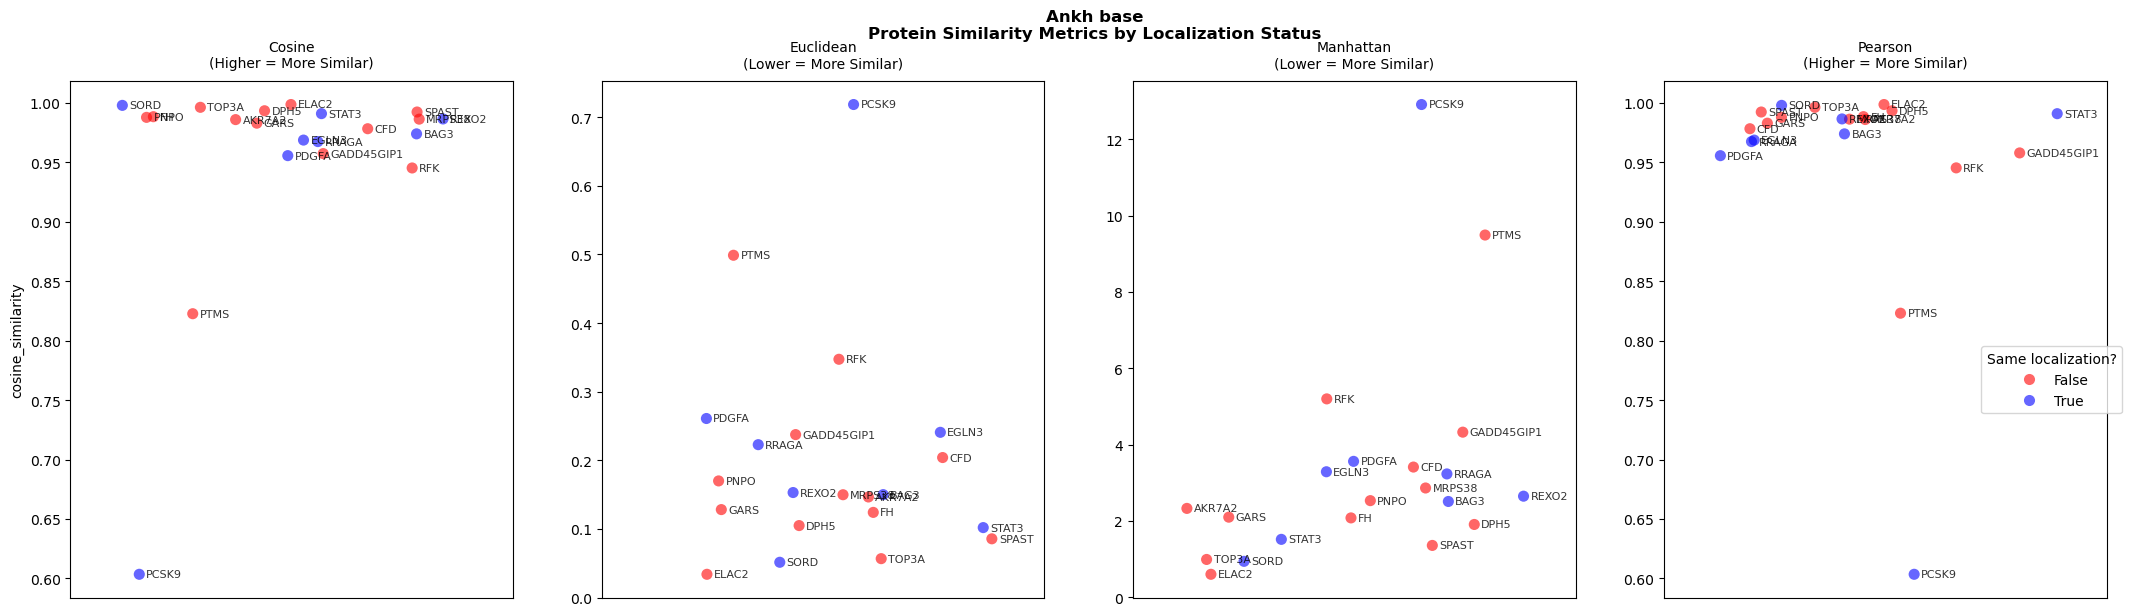


Results for cosine_similarity:
Correlation with Same_Localization: -0.223
T-test p-value: 0.331

Summary Statistics:
Same Localization:
Mean: 0.931
Std: 0.133
Count: 8

Different Localization:
Mean: 0.970
Std: 0.047
Count: 13

Results for euclidean_similarity:
Correlation with Same_Localization: 0.191
T-test p-value: 0.406

Summary Statistics:
Same Localization:
Mean: 0.237
Std: 0.207
Count: 8

Different Localization:
Mean: 0.176
Std: 0.127
Count: 13

Results for manhattan_similarity:
Correlation with Same_Localization: 0.139
T-test p-value: 0.547

Summary Statistics:
Same Localization:
Mean: 3.827
Std: 3.780
Count: 8

Different Localization:
Mean: 3.015
Std: 2.326
Count: 13

Results for pearson_similarity:
Correlation with Same_Localization: -0.224
T-test p-value: 0.329

Summary Statistics:
Same Localization:
Mean: 0.931
Std: 0.133
Count: 8

Different Localization:
Mean: 0.971
Std: 0.047
Count: 13


In [28]:
embeddings_file = '/lab/barcheese01/mdiberna/plm_sandbox/output/isoform/ankh/isoform_sequences_ankh_base.csv'
similarity = calculate_similarities(embeddings_file, labels_file)
plot_protein_metrics(similarity, 'Ankh base')
results = analyze_metric_correlations(similarity)

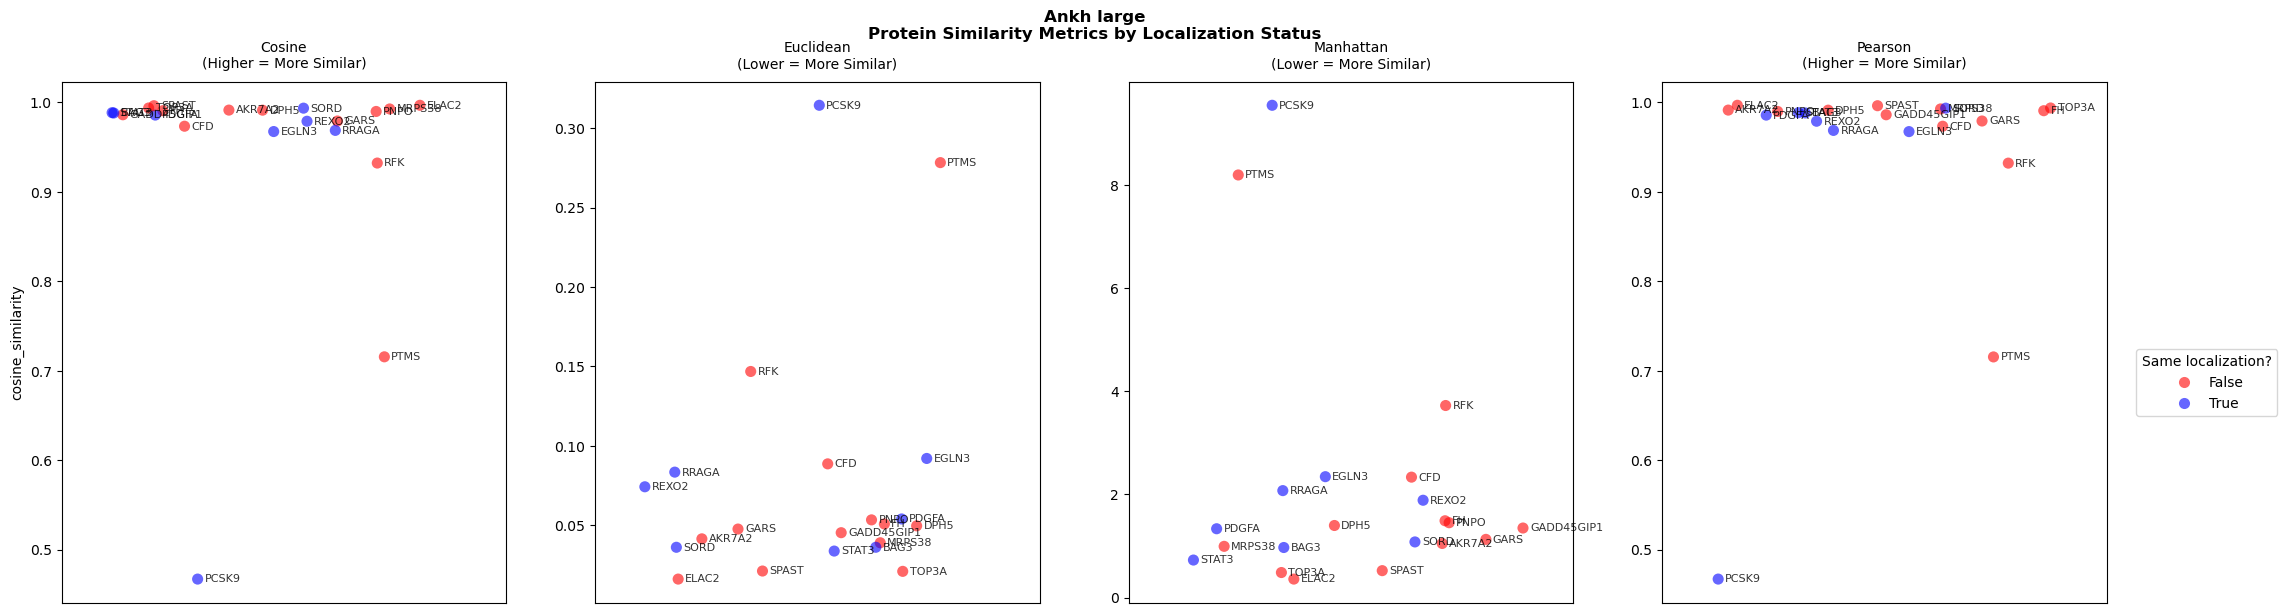


Results for cosine_similarity:
Correlation with Same_Localization: -0.185
T-test p-value: 0.422

Summary Statistics:
Same Localization:
Mean: 0.917
Std: 0.182
Count: 8

Different Localization:
Mean: 0.964
Std: 0.077
Count: 13

Results for euclidean_similarity:
Correlation with Same_Localization: 0.135
T-test p-value: 0.561

Summary Statistics:
Same Localization:
Mean: 0.091
Std: 0.093
Count: 8

Different Localization:
Mean: 0.069
Std: 0.071
Count: 13

Results for manhattan_similarity:
Correlation with Same_Localization: 0.128
T-test p-value: 0.580

Summary Statistics:
Same Localization:
Mean: 2.492
Std: 2.903
Count: 8

Different Localization:
Mean: 1.880
Std: 2.090
Count: 13

Results for pearson_similarity:
Correlation with Same_Localization: -0.185
T-test p-value: 0.422

Summary Statistics:
Same Localization:
Mean: 0.917
Std: 0.182
Count: 8

Different Localization:
Mean: 0.964
Std: 0.077
Count: 13


In [29]:
embeddings_file = '/lab/barcheese01/mdiberna/plm_sandbox/output/isoform/ankh/isoform_sequences_ankh_large.csv'
similarity = calculate_similarities(embeddings_file, labels_file)
plot_protein_metrics(similarity, 'Ankh large')
results = analyze_metric_correlations(similarity)

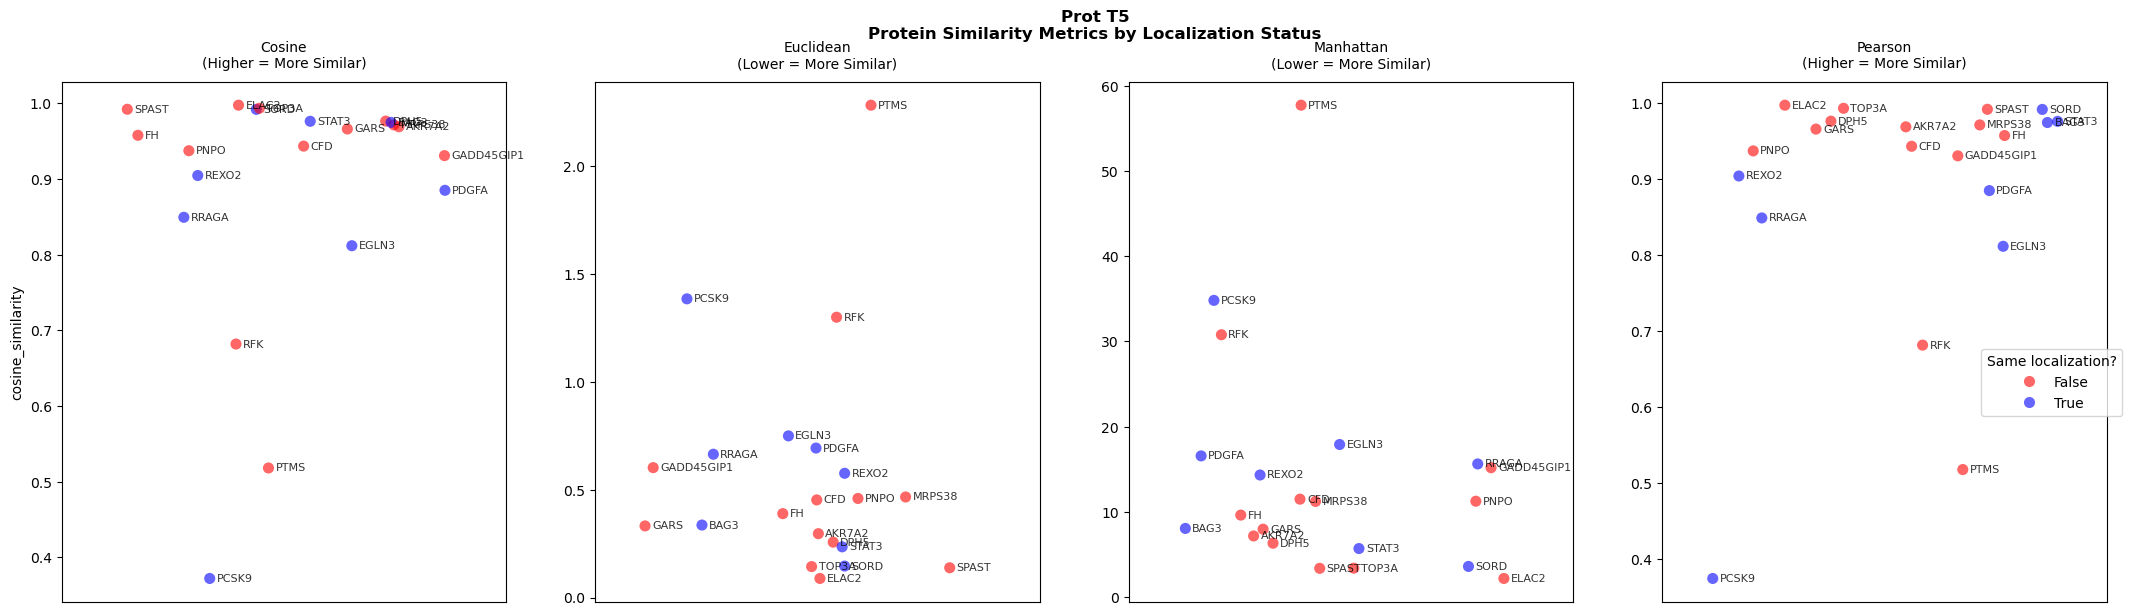


Results for cosine_similarity:
Correlation with Same_Localization: -0.194
T-test p-value: 0.400

Summary Statistics:
Same Localization:
Mean: 0.846
Std: 0.202
Count: 8

Different Localization:
Mean: 0.910
Std: 0.143
Count: 13

Results for euclidean_similarity:
Correlation with Same_Localization: 0.042
T-test p-value: 0.857

Summary Statistics:
Same Localization:
Mean: 0.597
Std: 0.389
Count: 8

Different Localization:
Mean: 0.554
Std: 0.602
Count: 13

Results for manhattan_similarity:
Correlation with Same_Localization: 0.034
T-test p-value: 0.882

Summary Statistics:
Same Localization:
Mean: 14.574
Std: 9.772
Count: 8

Different Localization:
Mean: 13.669
Std: 15.120
Count: 13

Results for pearson_similarity:
Correlation with Same_Localization: -0.193
T-test p-value: 0.401

Summary Statistics:
Same Localization:
Mean: 0.846
Std: 0.201
Count: 8

Different Localization:
Mean: 0.910
Std: 0.143
Count: 13


In [30]:
embeddings_file = '/lab/barcheese01/mdiberna/plm_sandbox/output/isoform/prot_t5/isoform_sequences_prot_t5.csv'
similarity = calculate_similarities(embeddings_file, labels_file)
plot_protein_metrics(similarity, 'Prot T5')
results = analyze_metric_correlations(similarity)

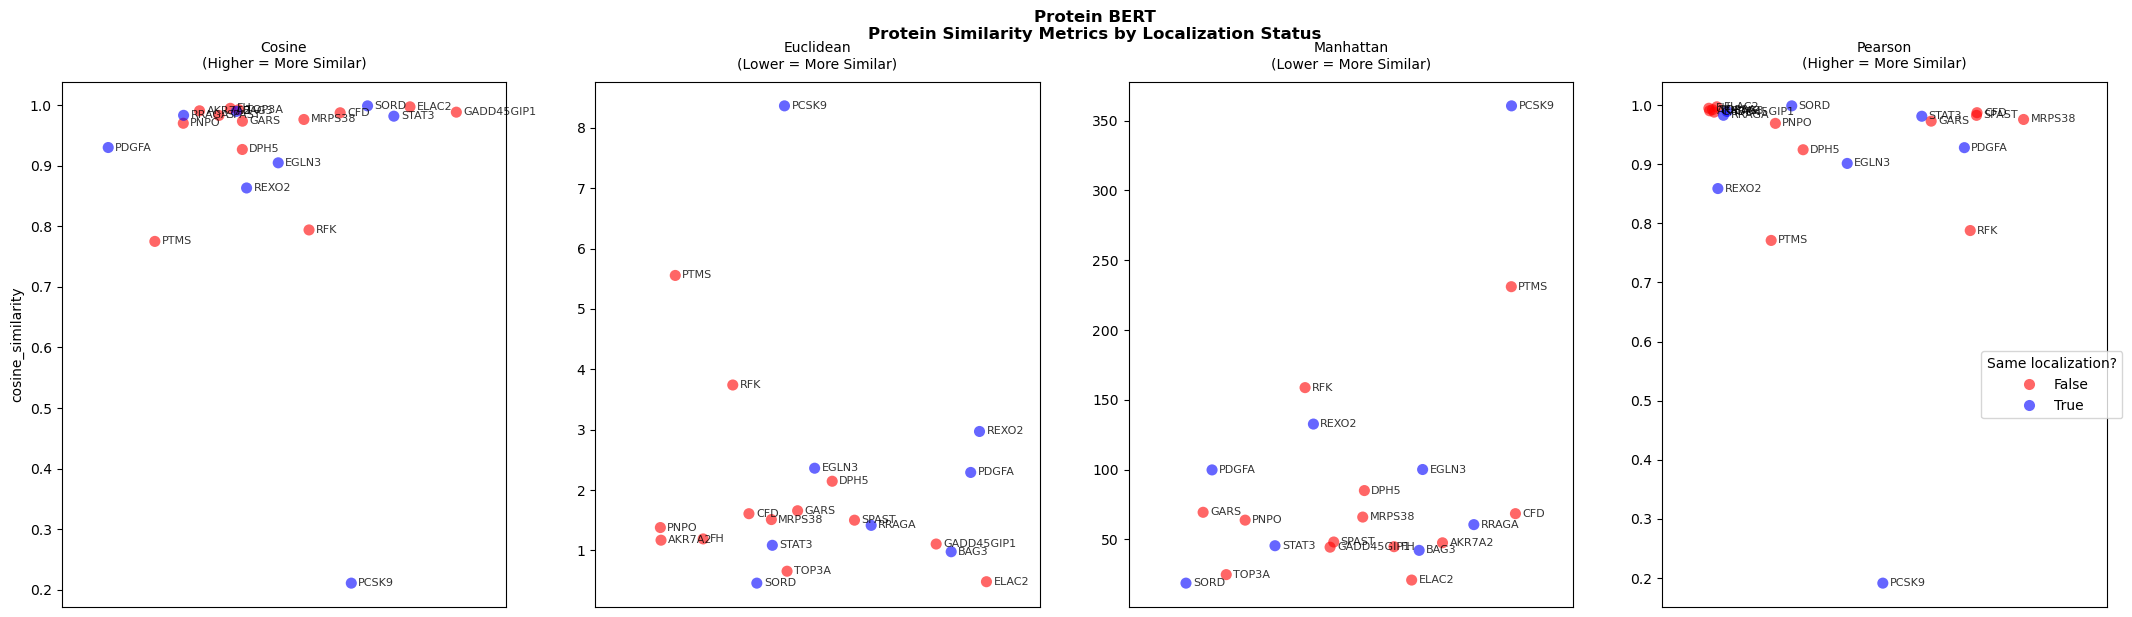


Results for cosine_similarity:
Correlation with Same_Localization: -0.264
T-test p-value: 0.248

Summary Statistics:
Same Localization:
Mean: 0.858
Std: 0.266
Count: 8

Different Localization:
Mean: 0.950
Std: 0.076
Count: 13

Results for euclidean_similarity:
Correlation with Same_Localization: 0.178
T-test p-value: 0.439

Summary Statistics:
Same Localization:
Mean: 2.490
Std: 2.517
Count: 8

Different Localization:
Mean: 1.823
Std: 1.375
Count: 13

Results for manhattan_similarity:
Correlation with Same_Localization: 0.202
T-test p-value: 0.379

Summary Statistics:
Same Localization:
Mean: 107.492
Std: 108.880
Count: 8

Different Localization:
Mean: 74.848
Std: 58.097
Count: 13

Results for pearson_similarity:
Correlation with Same_Localization: -0.265
T-test p-value: 0.246

Summary Statistics:
Same Localization:
Mean: 0.854
Std: 0.272
Count: 8

Different Localization:
Mean: 0.949
Std: 0.077
Count: 13


In [31]:
embeddings_file = '/lab/barcheese01/mdiberna/plm_sandbox/output/isoform/proteinbert/isoform_sequences_proteinbert.csv'
similarity = calculate_similarities(embeddings_file, labels_file)
plot_protein_metrics(similarity, 'Protein BERT')
results = analyze_metric_correlations(similarity)

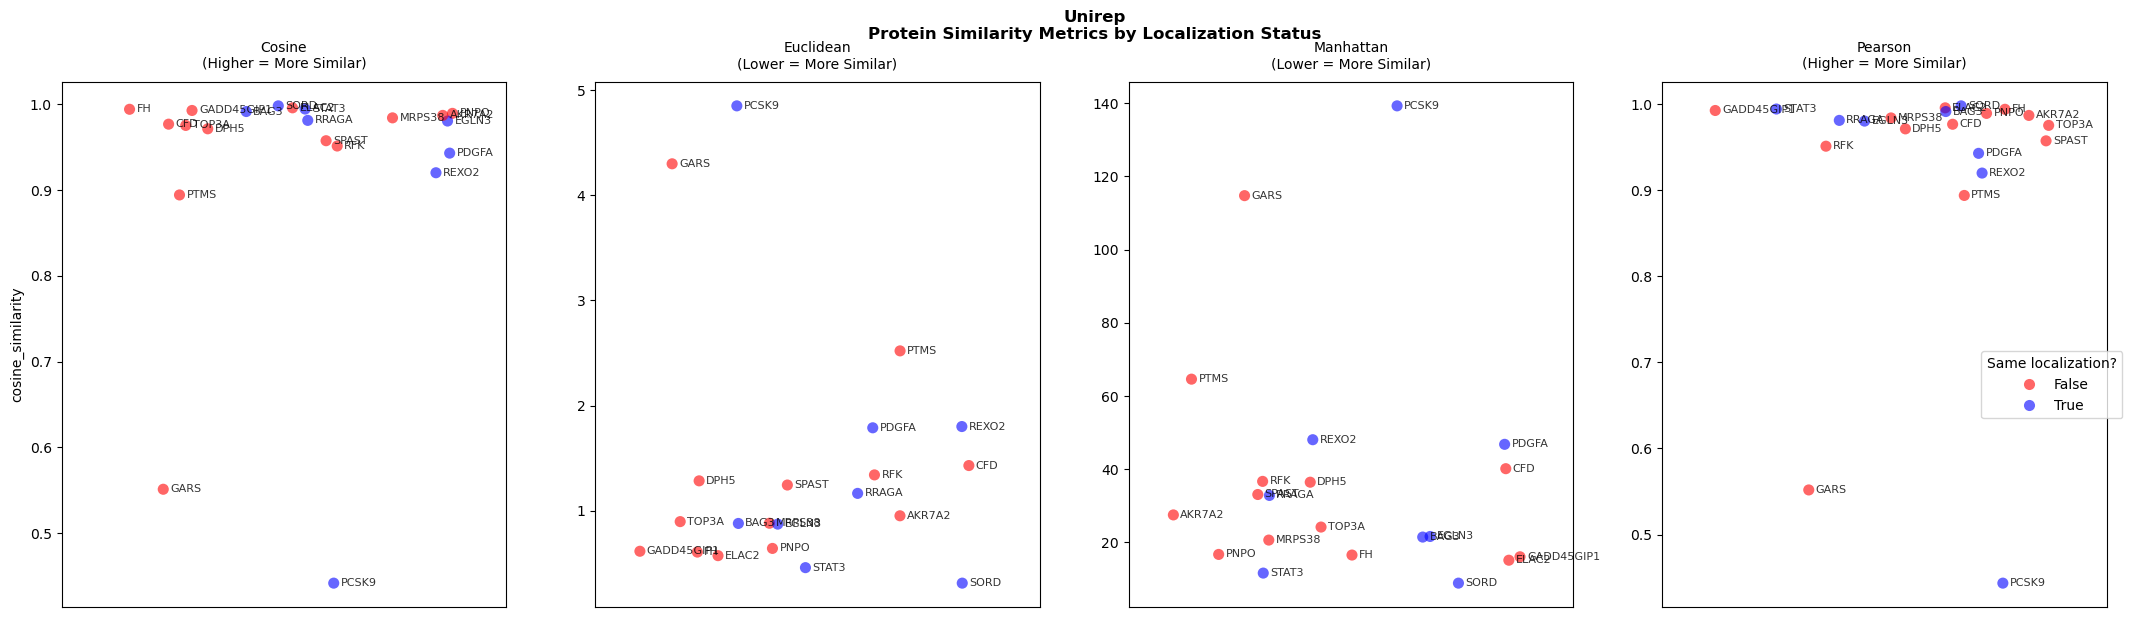


Results for cosine_similarity:
Correlation with Same_Localization: -0.114
T-test p-value: 0.621

Summary Statistics:
Same Localization:
Mean: 0.906
Std: 0.190
Count: 8

Different Localization:
Mean: 0.940
Std: 0.120
Count: 13

Results for euclidean_similarity:
Correlation with Same_Localization: 0.079
T-test p-value: 0.735

Summary Statistics:
Same Localization:
Mean: 1.515
Std: 1.454
Count: 8

Different Localization:
Mean: 1.329
Std: 1.036
Count: 13

Results for manhattan_similarity:
Correlation with Same_Localization: 0.087
T-test p-value: 0.709

Summary Statistics:
Same Localization:
Mean: 41.337
Std: 42.180
Count: 8

Different Localization:
Mean: 35.600
Std: 27.490
Count: 13

Results for pearson_similarity:
Correlation with Same_Localization: -0.114
T-test p-value: 0.622

Summary Statistics:
Same Localization:
Mean: 0.907
Std: 0.189
Count: 8

Different Localization:
Mean: 0.940
Std: 0.120
Count: 13


In [32]:
embeddings_file = '/lab/barcheese01/mdiberna/plm_sandbox/output/isoform/unirep/isoform_sequences_unirep.csv'
similarity = calculate_similarities(embeddings_file, labels_file)
plot_protein_metrics(similarity, 'Unirep')
results = analyze_metric_correlations(similarity)